In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )

# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")


/home/greg/data/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
data_path = '~/data/current/NMEG_utils/processed_data/daily_aflx/'
fig_path = '../figures/multiyear_figs/'
# Years to load
start = 2007
end = 2015
sites = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']
# Fill a dict with multiyear dataframes for each site in sites
daily = { x : 
         ld.load_local_daily_file( data_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }
d = pd.Panel(daily)

Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Seg_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Ses_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Wjs_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Mpj_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcp_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcm_daily_aflx.csv


## Remove Mixed Conifer data after the fire

In [3]:
# Note original dataframe shape preserved (but nans are produced)
d.Vcm = d.Vcm[ d.Vcm.index < dt.datetime(2013, 5, 3) ]
d.Vcm.tail()

,GPP_g_int,RECO_g_int,FC_F_g_int,ET_mm_24hint_0,P_F_sum,TA_F_avg,RH_F_avg,SW_IN_F_avg,RNET_F_avg,VPD_F_avg,PAR_avg,TA_F_min,VPD_F_min,TA_F_max,VPD_F_max,ET_mm_dayint,PET_mm_dayint
2015-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate multi-year drought statistics

In [6]:
# To assess drought we'll need to modify the climatologies by
# calculating means for drought/non-drought years
def mod_clim( clim ):
    clim[ 'predrght_mean' ] = clim[['2007', '2008', '2009', '2010']].mean(axis=1)
    clim[ 'drght_mean' ] = clim[['2011', '2012']].mean(axis=1)
    clim[ 'postdrght_mean' ] = clim[['2013', '2014']].mean(axis=1)
    # Calculate anomalies from allyear mean for drought-post-drought
    clim[ 'predrght_mean_anom' ] = clim.predrght_mean - clim.allyr_mean
    clim[ 'drght_mean_anom' ] = clim.drght_mean - clim.allyr_mean
    clim[ 'postdrght_mean_anom' ] = clim.postdrght_mean - clim.allyr_mean
    clim[ 'drght_mean_preanom' ] = clim.drght_mean - clim.predrght_mean
    clim[ 'postdrght_mean_preanom' ] = clim.postdrght_mean - clim.predrght_mean

    for i in range(start, end):
        # column for each year
        clim[ str(i) ] = clim[ str(i )]
        clim[ str(i) + '_anom' ] = clim[ str(i )] - clim.allyr_mean
        clim[ str(i) + '_preanom' ] = clim[ str(i )] - clim.predrght_mean
    
    return clim

### Get modified climatologies for FC, GPP, RECO, etc

In [7]:
# Create dictionaries with modified climatology (see mod_clim)
# for each site
fc_clim = { s : mod_clim(tr.var_climatology( d[s].FC_F_g_int )) for s in sites}
gpp_clim = { s : mod_clim(tr.var_climatology( d[s].GPP_g_int )) for s in sites}
re_clim = { s : mod_clim(tr.var_climatology( d[s].RECO_g_int )) for s in sites}
p_clim = { s : mod_clim(tr.var_climatology( d[s].P_F_sum )) for s in sites}
vpd_clim = { s : mod_clim(tr.var_climatology( d[s].VPD_F_avg )) for s in sites}

fc_clim['Seg'].columns

Index(['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', 'allyr_mean', 'allyr_stdev', 'allyr_stderr', 'allyr_cv',
       'allyr_cv2', 'predrght_mean', 'drght_mean', 'postdrght_mean',
       'predrght_mean_anom', 'drght_mean_anom', 'postdrght_mean_anom',
       'drght_mean_preanom', 'postdrght_mean_preanom', '2007_anom',
       '2007_preanom', '2008_anom', '2008_preanom', '2009_anom',
       '2009_preanom', '2010_anom', '2010_preanom', '2011_anom',
       '2011_preanom', '2012_anom', '2012_preanom', '2013_anom',
       '2013_preanom', '2014_anom', '2014_preanom'],
      dtype='object')

### Set up plots

In [9]:
# Set x limits
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2015, 12, 31 )]

# Plot definition for one-site axis showing Multiyear mean + individual years in background
def plot_multiyr_lines( ax_in, clim, climcols, meancolor, 
                       syr=start, eyr=end, plterr=False,
                       indyrs=False, hilite=[None] ):
    if type(climcols) == type(str()):
        climcols = [climcols,]
        plterr = True
        meancolor = [meancolor,]
    else:
        meancolor = [meancolor,'red','gray']
            
    # If requested, plot individual years
    if indyrs: 
        for i in range( syr, eyr+1 ):
            # If requested, highlight a particular year in red
            if i in hilite:
                hicolour='Red'
            else:
                hicolour=[0.7, 0.7, 0.7]
            # Plot the individual year line (mean + anomaly)
            ax_in.plot(clim.index, clim[ str(i) ], 
                       color=hicolour, lw=0.5)
    #ls = ['-', '--', ':']
    for j, col in enumerate(climcols):
        if j > 0:
            ax_in.plot(clim.index, clim[col], color=meancolor[j], lw=0.5)
        else:
            ax_in.plot(clim.index, clim[col], color=meancolor[j])
        # Plot error of mean if requested
        if plterr:
            ax_in.plot(clim.index, clim[col] + clim.allyr_stderr, color=meancolor[j], alpha=.4)
            ax_in.plot(clim.index, clim[col] - clim.allyr_stderr, color=meancolor[j], alpha=.4)
    
# Plot definition for a 3 x 2 plot of multiyear mean fluxes
def plot_multiyr_mean_sites( clim_in, clim_cols, varname, texty, fighandle, ind_yrs=False,
                            xlims=[0,366], ylims=[-10,10], sitelist=sites,
                            sitenames=nmegplt.longnames, colors=nmegplt.palette, hilite_yr=None ):
    # If input is a list RE is pos, GPP is neg
    if type(clim_in) is list:
        clim = clim_in[0]
        clim2 = clim_in[1]
    else:
        clim = clim_in
    # Loop through sites/subplots
    ax = list();
    for i, site in enumerate(sitelist):
        ax.append(fighandle.add_subplot(len(sitelist)/2, 2, i+1))
        plt.plot( xlims, [0, 0], ':k')
        plot_multiyr_lines( ax[i], clim[site], clim_cols, colors[site], hilite=[hilite_yr], indyrs=ind_yrs )
        # If requested plot a series negative (usually GPP)
        if type(clim_in) is list:
            plot_multiyr_lines( ax[i], -clim2[site], clim_cols, colors[site], hilite=[hilite_yr], indyrs=ind_yrs )
        plt.ylim( ylims )
        plt.xlim( xlims )
        plt.text( 10, texty, sitenames[site], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        #ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))
        if i < len(sitelist)-2:
            plt.setp( ax[i].get_xticklabels(), visible=False)
        else:
            plt.setp( ax[i].get_xticklabels(), fontsize=14)
            
    for i in (0, 2, 4):
        ax[i].set_ylabel('Mean ' + varname + '\n$g\ C\ m^2$', fontsize=14)
        
    return ax

## Plot multiyear C flux means for pre/post/drought

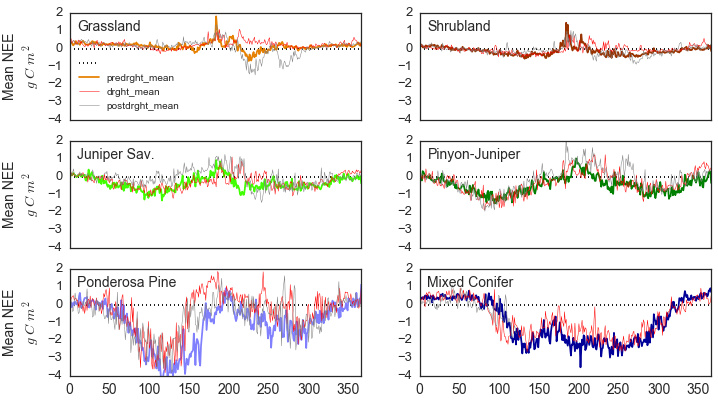

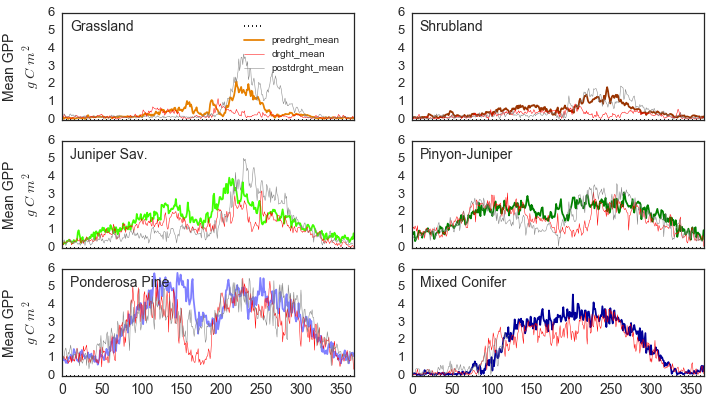

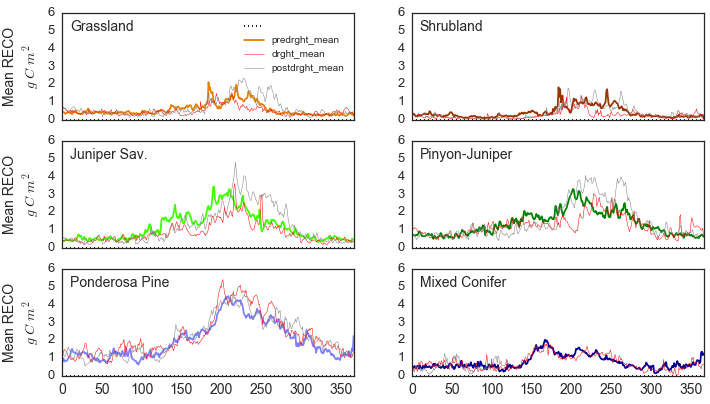

In [10]:
ylims = [ -4, 2 ]

figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( fc_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'NEE', 1, figX, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])
ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='lower left')

ylims = [ 0, 6 ]
figY = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( gpp_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'GPP', 5, figY, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])
ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='upper right')

figZ = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( re_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'RECO', 5, figZ, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])

ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='upper right')

## Plot mean daily values for all drought periods

### Limit to growing season

The next several plots are limited to growing season only.

In [11]:
startseas = 90
endseas = 300

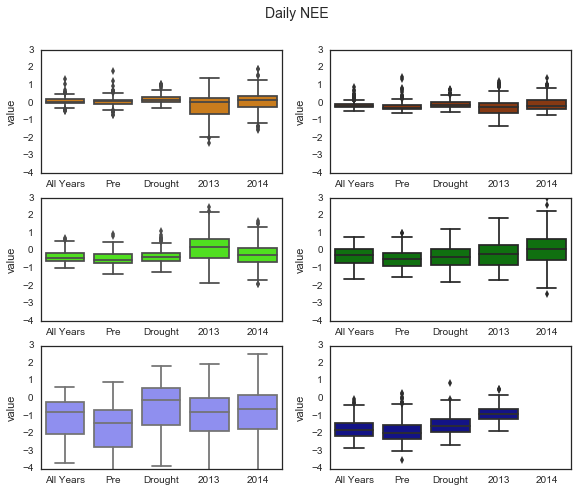

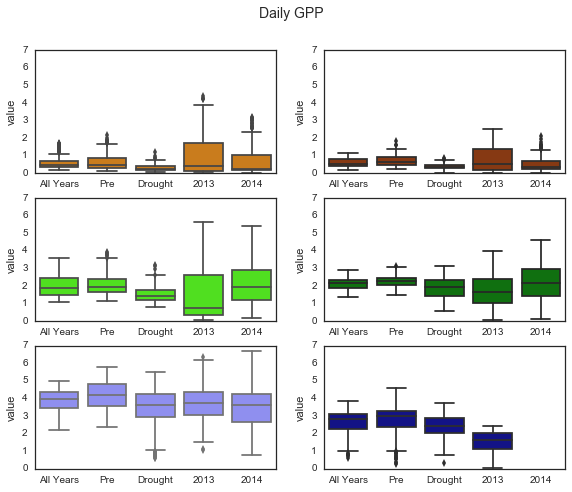

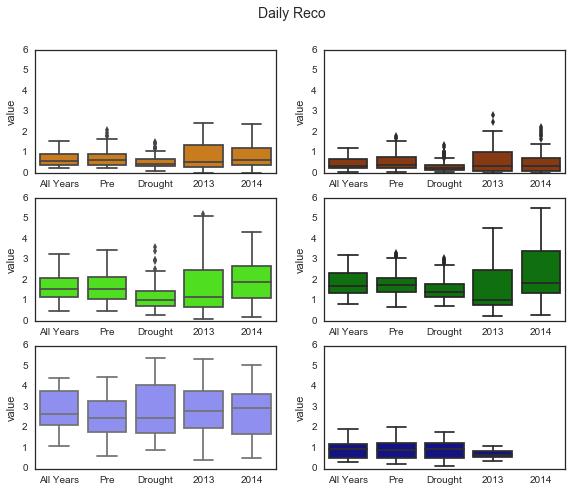

In [18]:
def plot_drought_dist( clim, fig, y_limit, anom=False, preanom=False ):
    for i, site in enumerate(sites):
        # Limit to growing season only
        data = clim[site].iloc[startseas:endseas]
        if anom:
            #subset = pd.melt(data[['predrght_mean_anom', 'drght_mean_anom',
            #                       'postdrght_mean_anom']])
            subset = pd.melt(data[['predrght_mean_anom', 'drght_mean_anom',
                                   '2013_anom', '2014_anom']])
            xlabels = ['Pre', 'Drought', '2013', '2014']
        elif preanom:
            subset = pd.melt(data[['drght_mean_preanom',
                                   '2013_preanom', '2014_preanom']])
            xlabels = ['Drought', '2013', '2014']
        else:
            #subset = pd.melt(data[['allyr_mean','predrght_mean', 'drght_mean',
            #                       'postdrght_mean']])
            subset = pd.melt(data[['allyr_mean','predrght_mean', 'drght_mean',
                                   '2013', '2014']])
            xlabels = ['All Years', 'Pre', 'Drought', '2013', '2014']
        
        ax = fig.add_subplot(len(clim.keys())/2, 2, i+1)    
        sns.boxplot(x='variable', y='value', data=subset, color=nmegplt.palette[site])
        ax.set_xlabel('')
        #ax.set_xticklabels(['Pre', 'Drought', 'Post'])
        ax.set_xticklabels(xlabels)
        ax.set_ylim(y_limit)

figX = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-4, 3])
plt.suptitle('Daily NEE', size=14)
    
figY = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [0, 7])
plt.suptitle('Daily GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [0, 6])
plt.suptitle('Daily Reco', size=14)

## Anomalies w/ respect to all year mean

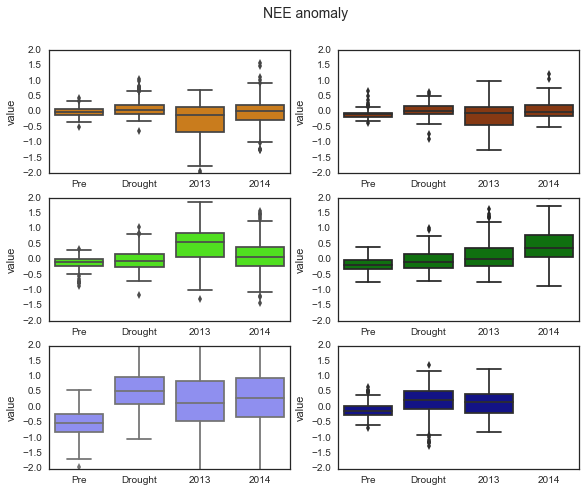

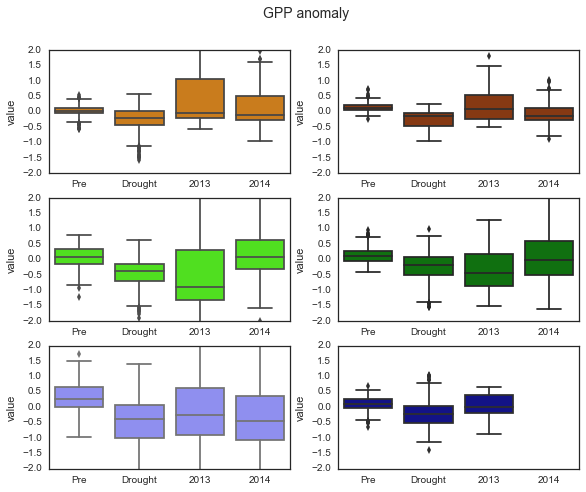

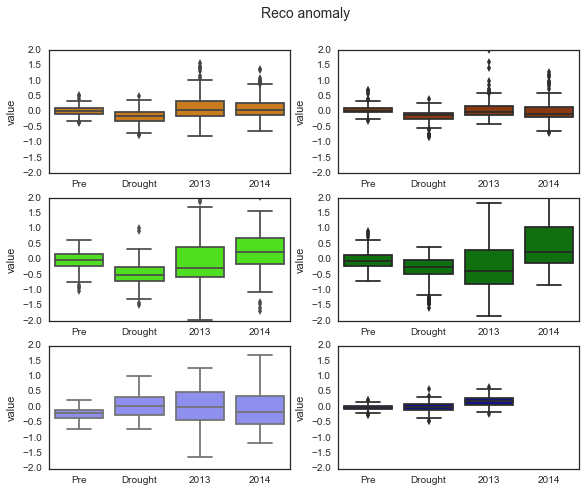

In [17]:
figX = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-2, 2], anom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [-2, 2], anom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [-2, 2], anom=True)
plt.suptitle('Reco anomaly', size=14)

## Anomalies w/ respect to pre-drought mean (2007-2010)

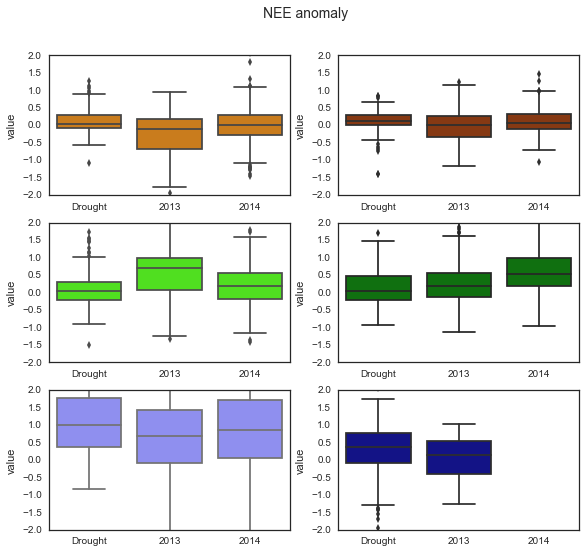

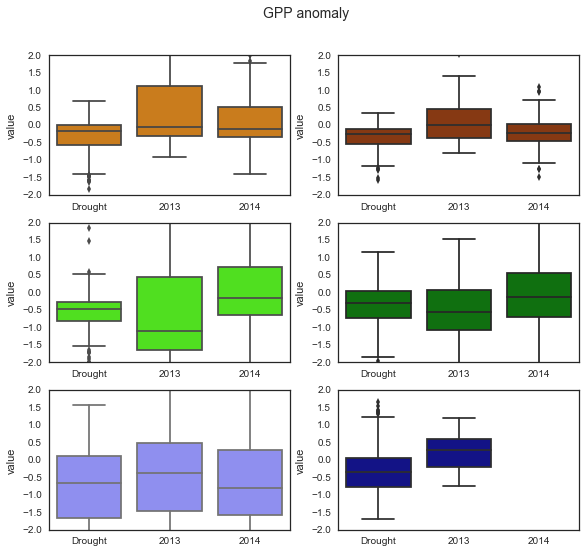

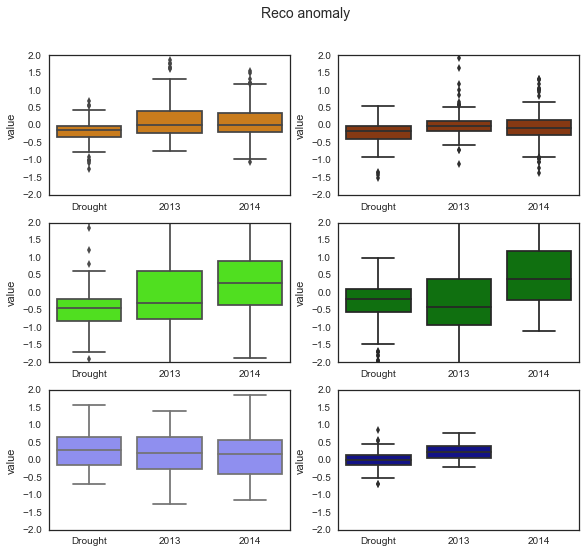

In [14]:
figX = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-2, 2], preanom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [-2, 2], preanom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [-2, 2], preanom=True)
plt.suptitle('Reco anomaly', size=14)

## Histograms/KDEs of daily flux values

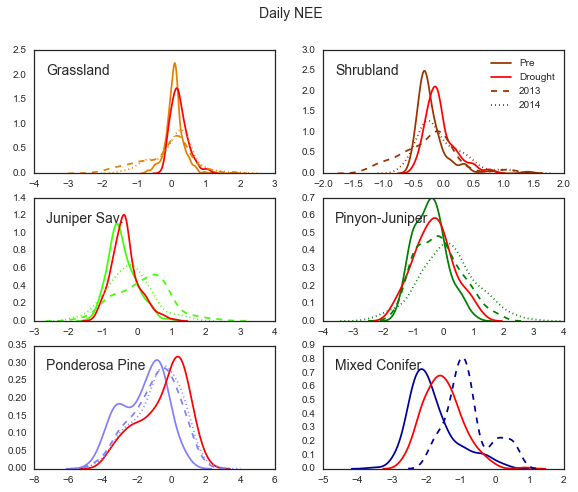

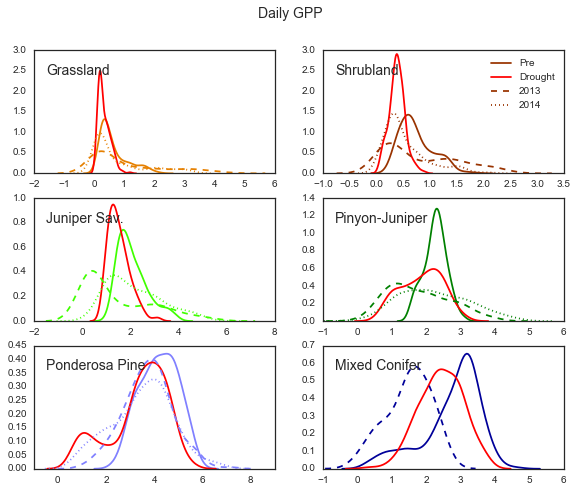

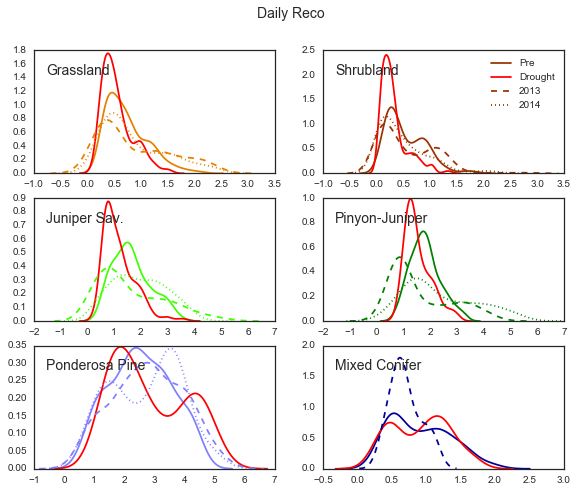

In [19]:
def plot_drought_kde( clim, fig, anom=False, preanom=False ):
    for i, site in enumerate(sites):
        # Limit to growing season only
        data = clim[site].iloc[startseas:endseas]
        ax = fig.add_subplot(len(clim.keys())/2, 2, i+1)
        if anom:
            ax.set_xlim([-2, 2])
            kde_vars = ['predrght_mean_anom','drght_mean_anom','2013_anom','2014_anom']
            legend_label = ['Pre', 'Drought', '2013', '2014']
        elif preanom:
            ax.set_xlim([-2, 2])
            kde_vars = ['drght_mean_preanom','2013_preanom','2014_preanom']
            legend_label = ['Drought', '2013', '2014']
        else:
            #ax.set_xlim([-2, 2])
            kde_vars = ['predrght_mean','drght_mean','2013','2014']
            legend_label = ['Pre', 'Drought', '2013', '2014']
        
        if site!='Vcm' and preanom==False:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color=nmegplt.palette[site])
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[site], ls='--')
            sns.kdeplot(data[kde_vars[3]].dropna(), legend=False, color=nmegplt.palette[site], ls=':')
        elif site!='Vcm' and preanom==True:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color=nmegplt.palette[site])
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[site], ls='--')
        elif site=='Vcm' and preanom==False:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color=nmegplt.palette[site])
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[site], ls='--')
        elif site=='Vcm' and preanom==True:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color=nmegplt.palette[site])
        
        plt.text( .05, .8, nmegplt.longnames[site], size=14, transform=ax.transAxes  )
        ax.set_xlabel('')
        if i==1:
            #plt.legend(['Pre', 'Post', 'Drought'])
            plt.legend(legend_label)
        
figX = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX)
plt.suptitle('Daily NEE', size=14)
    
figY = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY)
plt.suptitle('Daily GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ)
plt.suptitle('Daily Reco', size=14)

## Histograms/KDEs of daily anomaly (wrt all years)

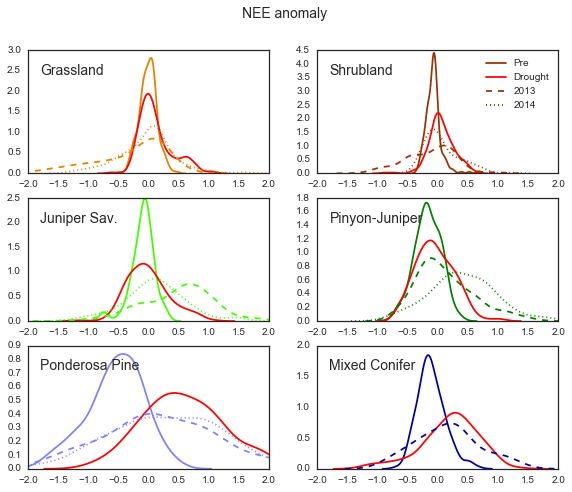

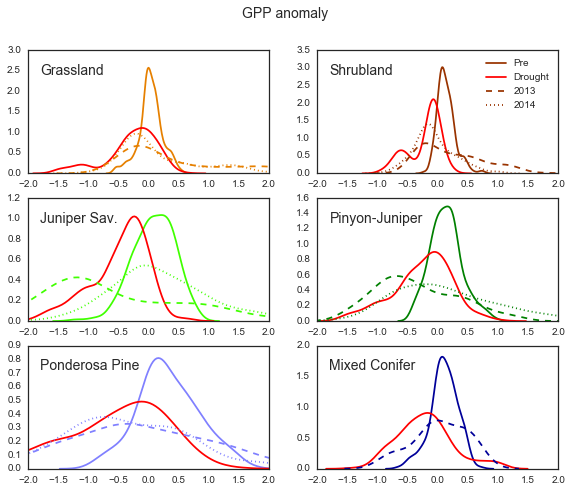

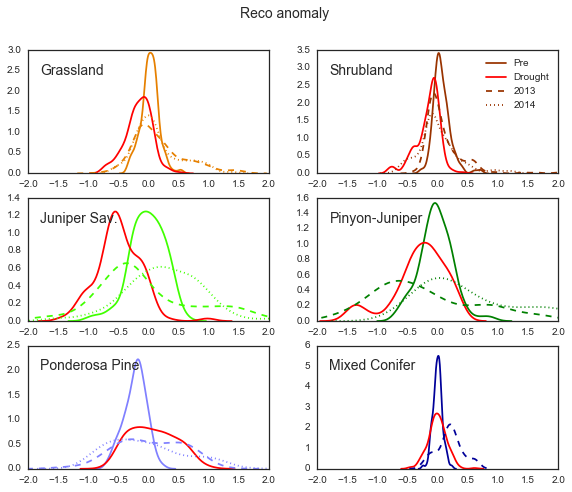

In [20]:
figX = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX, anom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY, anom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ, anom=True)
plt.suptitle('Reco anomaly', size=14)

## Histograms/KDEs of daily anomaly (wrt pre-drought years)

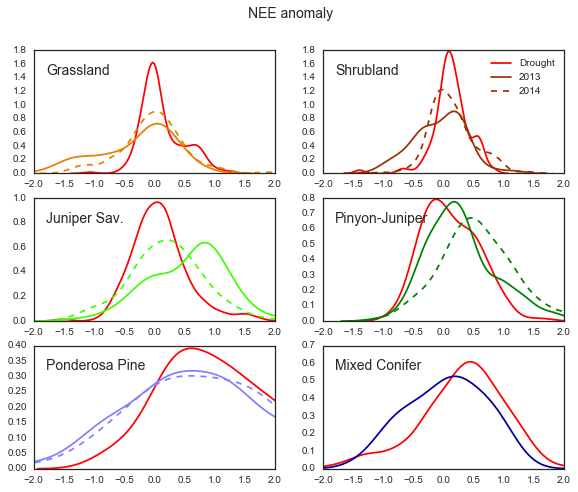

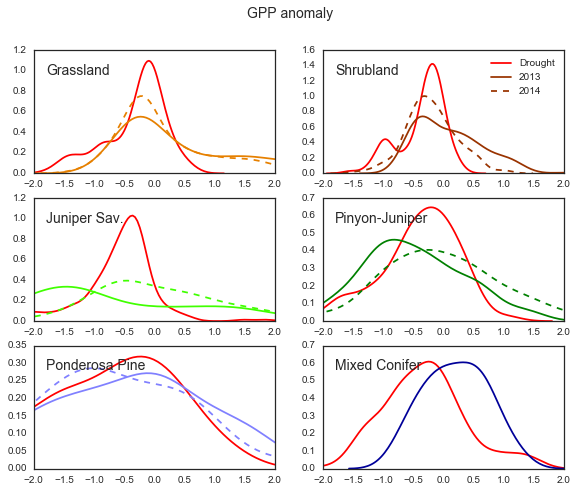

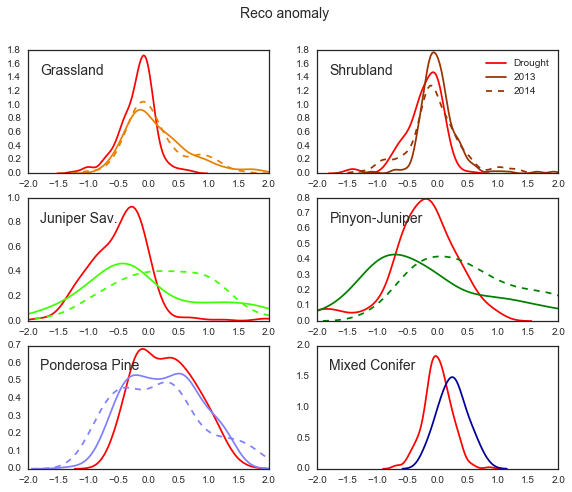

In [21]:
figX = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX, preanom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY, preanom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ, preanom=True)
plt.suptitle('Reco anomaly', size=14)

## Table of cumulative values

* Summed g C/m2 during the different periods we are interested in (pre-, post-, drought, and all year means)
* Differences between pre-drought/potential cumulative values and and drought/post-drought periods
* Percentage of pre-drought and potential cumulative flux


In [22]:
indices = ['AllYr Mean', 'Pre','Drought', 'Post', 'Potential', 
           'Pre-Drought', 'Drought % of pre', 'Pre-Post','Post % of pre',
           'Pot.-Drought', 'Drought % of pot.', 'Pot.-Post', 'Post % of pot.']
nee_t = pd.DataFrame(columns=sites, index = indices)
gpp_t = pd.DataFrame(columns=sites, index = indices)
reco_t = pd.DataFrame(columns=sites, index = indices)

for i, site in enumerate(sites):
        
    # Sum up the climatology columns for the site
    sums = fc_clim[site].sum()
    nee_t[site].loc['AllYr Mean'] = sums.allyr_mean
    nee_t[site].loc['Pre'] = sums.predrght_mean
    nee_t[site].loc['Drought'] = sums.drght_mean
    nee_t[site].loc['Post'] = sums.postdrght_mean
    nee_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    nee_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    nee_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    nee_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
    sums = gpp_clim[site].sum()
    gpp_t[site].loc['AllYr Mean'] = sums.allyr_mean
    gpp_t[site].loc['Pre'] = sums.predrght_mean
    gpp_t[site].loc['Drought'] = sums.drght_mean
    gpp_t[site].loc['Post'] = sums.postdrght_mean
    gpp_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    gpp_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    gpp_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    gpp_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
    sums = re_clim[site].sum()
    reco_t[site].loc['AllYr Mean'] = sums.allyr_mean
    reco_t[site].loc['Pre'] = sums.predrght_mean
    reco_t[site].loc['Drought'] = sums.drght_mean
    reco_t[site].loc['Post'] = sums.postdrght_mean
    reco_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    reco_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    reco_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    reco_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
nee_t

,Seg,Ses,Wjs,Mpj,Vcp,Vcm
AllYr Mean,57.4223,-25.7437,-99.5031,-122.769,-277.541,-329.085
Pre,55.2135,-45.2686,-134.059,-169.65,-396.876,-345.787
Drought,86.0908,-10.3374,-97.3292,-126.118,-131.534,-289.881
Post,23.2075,-33.917,-21.7236,-67.1667,-257.21,-11.5102
Potential,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Drought,-30.8773,-34.9312,-36.7293,-43.5321,-265.342,-55.9061
Drought % of pre,155.924,22.8358,72.602,74.34,33.1423,83.8322
Pre-Post,32.006,-11.3516,-112.335,-102.483,-139.666,-334.277
Post % of pre,42.0324,74.9238,16.2046,39.5914,64.8087,3.32869
Pot.-Drought,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
gpp_t

,Seg,Ses,Wjs,Mpj,Vcp,Vcm
AllYr Mean,150.379,156.842,524.491,636.362,1078.07,607.092
Pre,155.672,192.141,559.838,671.173,1132.26,626.099
Drought,92.3454,104.944,410.157,577.026,959.766,562.646
Post,218.256,171.508,462.622,610.931,1049.12,78.6428
Potential,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Drought,63.3263,87.1971,149.681,94.147,172.494,63.4535
Drought % of pre,59.3206,54.6182,73.2636,85.9728,84.7655,89.8653
Pre-Post,-62.5839,20.6333,97.216,60.2415,83.1395,547.456
Post % of pre,140.203,89.2614,82.635,91.0244,92.6572,12.5608
Pot.-Drought,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
reco_t

,Seg,Ses,Wjs,Mpj,Vcp,Vcm
AllYr Mean,207.801,131.098,424.988,513.593,800.527,278.007
Pre,210.885,146.872,425.78,501.523,735.383,280.312
Drought,178.436,94.6065,312.828,450.908,828.232,272.764
Post,241.463,137.591,440.899,543.764,791.91,67.1326
Potential,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Drought,32.4489,52.266,112.951,50.6149,-92.8487,7.54742
Drought % of pre,84.613,64.414,73.4719,89.9078,112.626,97.3075
Pre-Post,-30.5779,9.28168,-15.119,-42.2416,-56.5265,213.179
Post % of pre,114.5,93.6805,103.551,108.423,107.687,23.9493
Pot.-Drought,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-Post-During Drought calculations

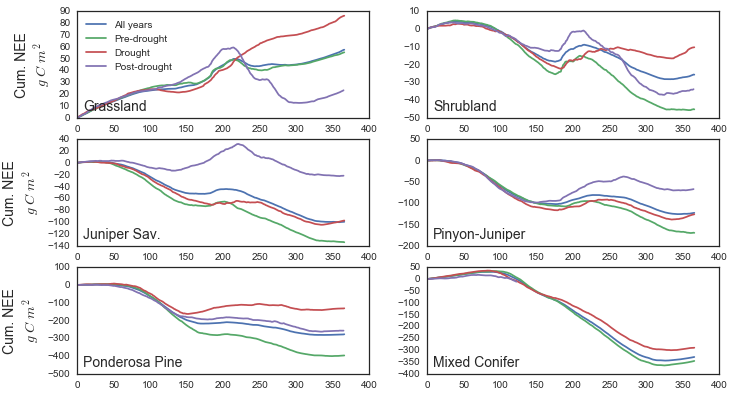

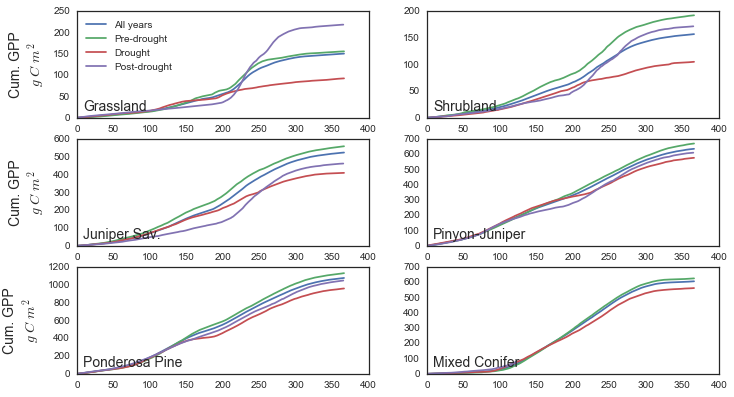

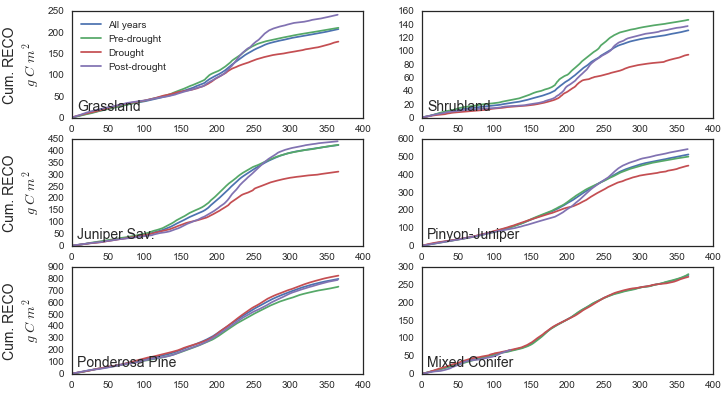

In [25]:
def plot_cumulative_drought( clim, fig, label ):
    ax = list();
    for i, site in enumerate(sites):
        ax.append(fig.add_subplot(len(sites)/2, 2, i+1))
        plt.plot( clim[site].index,  np.cumsum(clim[site].allyr_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].predrght_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].drght_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].postdrght_mean))
            
        #plt.xlim( xlims )
        plt.text( .02, .07, nmegplt.longnames[site], size=14, transform=ax[i].transAxes )
        if i==0:
            plt.legend(['All years', 'Pre-drought', 'Drought','Post-drought'], loc='upper left')

    for i in (0, 2, 4):
            ax[i].set_ylabel('Cum. {0}\n$g\ C\ m^2$'.format(label), fontsize=14)
            
figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( fc_clim, figX, 'NEE' )

figY = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( gpp_clim, figY, 'GPP' )

figZ = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( re_clim, figZ, 'RECO' )

## Plot monthly mean anomalies

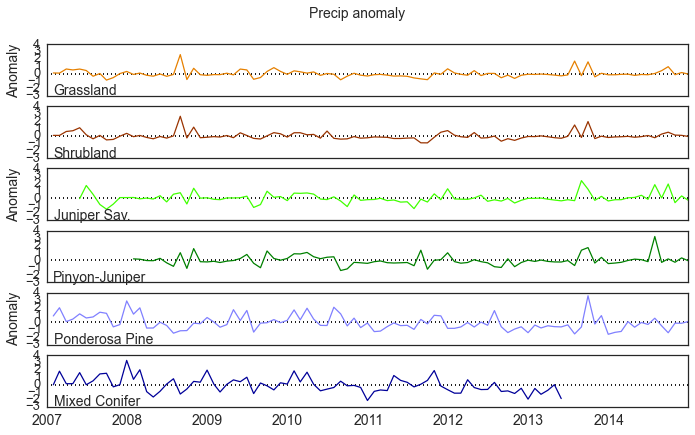

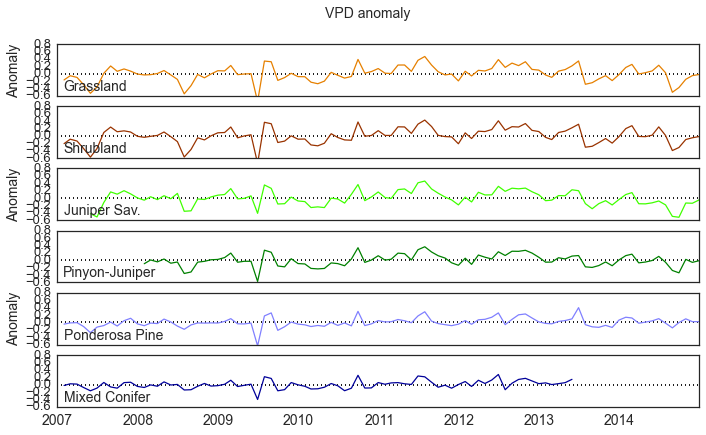

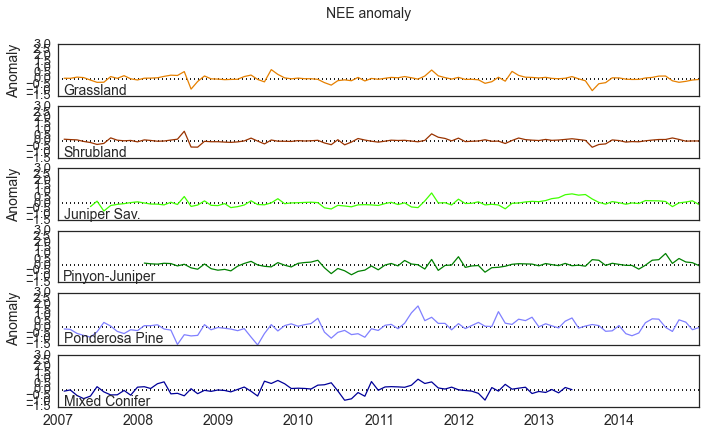

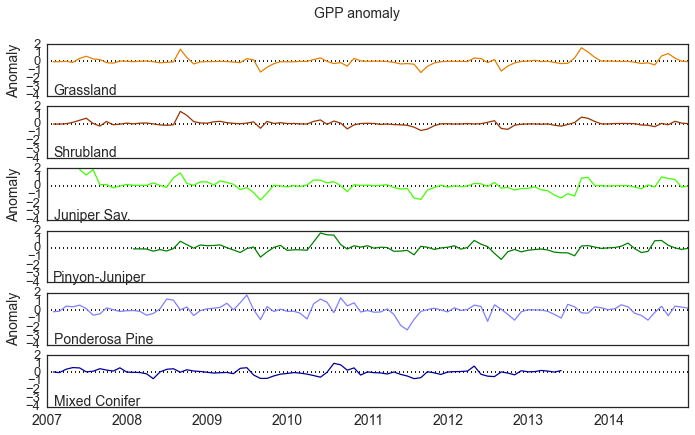

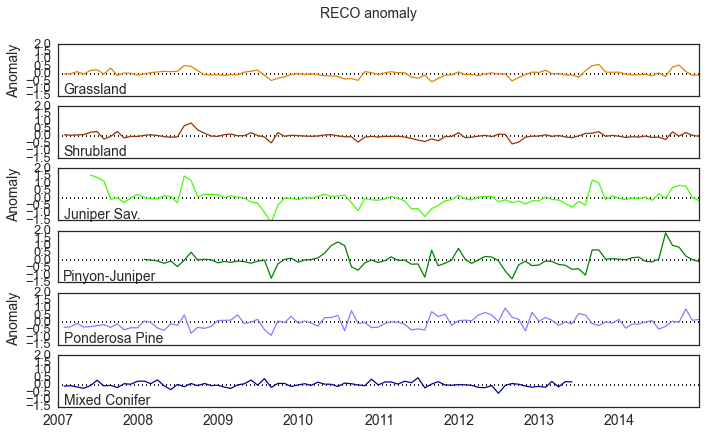

In [27]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

varlist = ['P_F','VPD_F','NEE_g_int','GPP_g_int','RECO_g_int']
ylabs = ['Precip anomaly', 'VPD anomaly', 'NEE anomaly', 'GPP anomaly', 'RECO anomaly']
ylims = [[-3, 4],[-0.6,0.8],[-1.5,3],[-4,2],[-1.5,2]]

for i, anom in enumerate([p_anom, vpd_anom, fc_anom, gpp_anom, re_anom]):
    # Resample anomaly to monthly mean
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    nmegplt.plot_tseries( anom_m, varlist[i], ylims[i][0]+0.15, fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i], size=14)


## Plot monthly mean normalized C flux anomaly

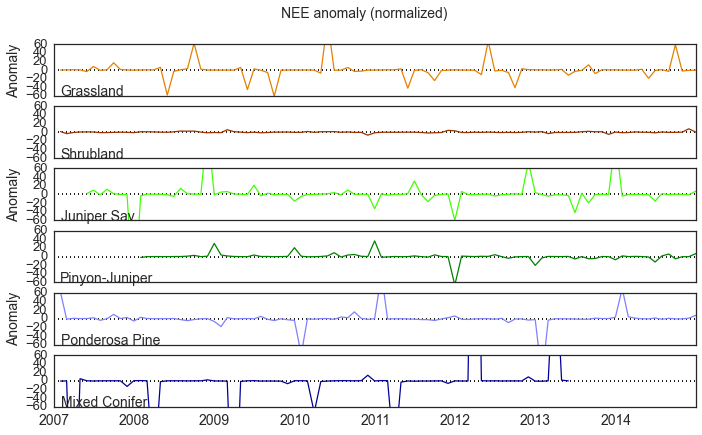

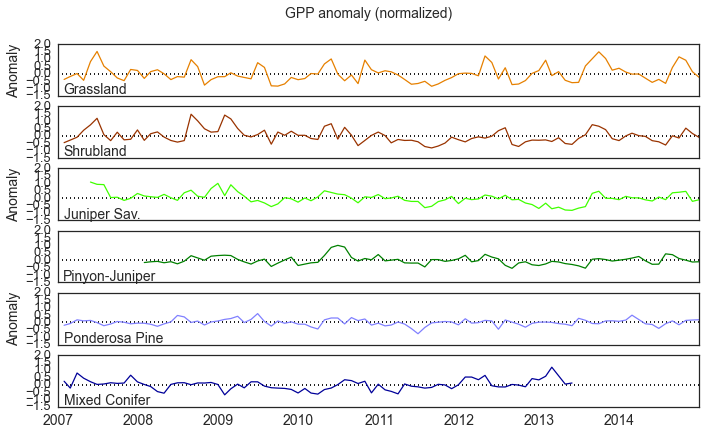

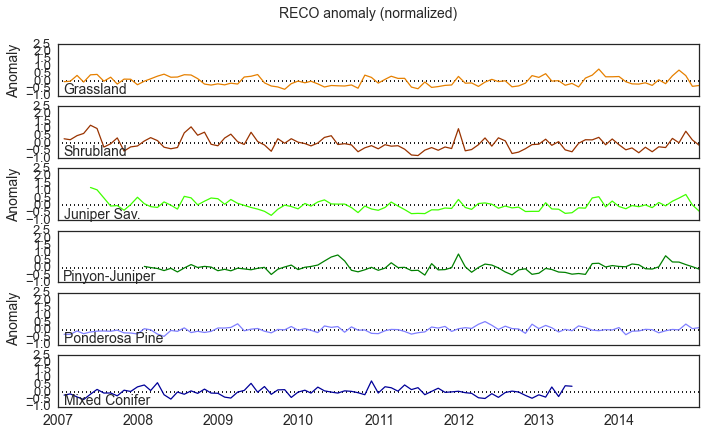

In [28]:
varlist = ['NEE_g_int','GPP_g_int','RECO_g_int']
ylabs = ['NEE anomaly', 'GPP anomaly', 'RECO anomaly']
ylims = [[-60,60],[-1.5,2],[-1,2.5]]

for i, anom in enumerate([fc_anom_n, gpp_anom_n, re_anom_n]):
    
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    nmegplt.plot_tseries( anom_m, varlist[i], ylims[i][0]+0.15, fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i] + ' (normalized)', size=14)
    


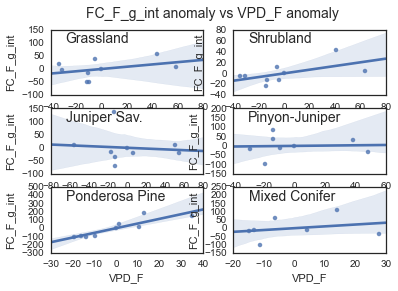

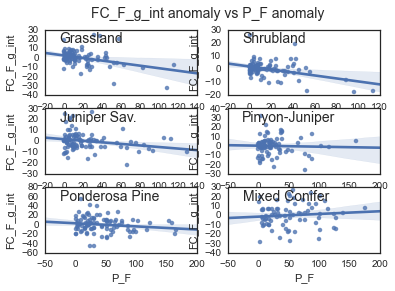

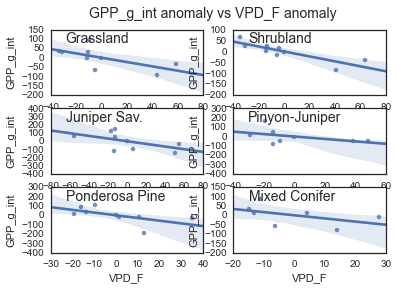

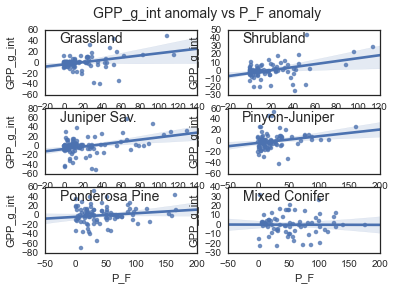

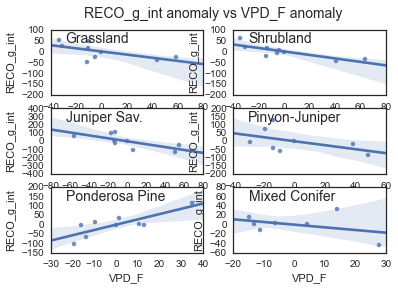

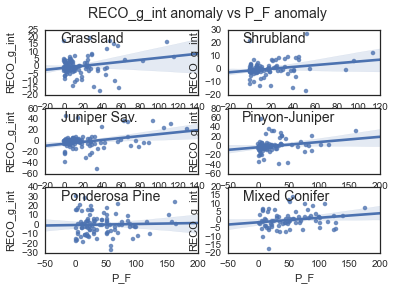

In [29]:
texty = 20
figX = plt.figure()

x_anoms = [vpd_anom, p_anom]
x_labels = ['VPD_F', 'P_F']
y_anoms = [fc_anom, gpp_anom, re_anom]
y_labels = [ 'FC_F_g_int', 'GPP_g_int', 'RECO_g_int']

for i in range(0, 3):
    figA = plt.figure()
    x_anom = x_anoms[0]
    y_anom = y_anoms[i]
    
    for j, site in enumerate(sites):
        x_y_anom = x_anom[ site ].resample('A',how='sum')
        y_y_anom = y_anom[ site ].resample('A',how='sum')
        df = pd.concat([x_y_anom, y_y_anom], axis=1)
        ax = figA.add_subplot(3, 2, j+1)
        sns.regplot(x_labels[0], y_labels[i], df)
        plt.text( .1, .8, nmegplt.names[j], size=14, transform = ax.transAxes  )
    plt.suptitle( y_labels[i] + ' anomaly vs ' + x_labels[0] + ' anomaly', size=14)
    
    figB = plt.figure()
    x_anom = x_anoms[1]
    
    
    for k, site in enumerate(sites):
        # Yearly summed precip
        x_y_anom = d[ site ].P_F.resample('M',how='sum')
        # Yearly summed precip anomaly
        #x_y_anom = x_anom[ site ].resample('M',how='sum')
        y_y_anom = y_anom[ site ].resample('M',how='sum')
        y_y_anom = y_y_anom.shift(-1)
        
        df = pd.concat([x_y_anom, y_y_anom], axis=1)
        ax = figB.add_subplot(3, 2, k+1)
        sns.regplot(x_labels[1], y_labels[i], df)
        plt.text( .1, .8, nmegplt.names[k], size=14, transform = ax.transAxes  )
    plt.suptitle( y_labels[i] + ' anomaly vs ' + x_labels[1] + ' anomaly', size=14)
